<a href="https://colab.research.google.com/github/saarzeev/MalisciousURLDetection/blob/main/Malicious_URL_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras
!pip install tld

     |████████████████████████████████| 412 kB 5.2 MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, concatenate, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras import losses
from tensorflow.keras.utils import to_categorical
from scipy import misc
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load dataset taken from https://www.kaggle.com/sid321axn/malicious-urls-dataset, so we can have some data to learn from

In [ ]:
folder='/content/drive/My Drive/perceptionPoint/' 
data = pd.read_csv(folder+'kaggle_malicious_urls_dataset.csv',engine="python")

In [ ]:
print(data.head())


                                                 url        type
0                                   br-icloud.com.br    phishing
1                mp3raid.com/music/krizz_kaliko.html      benign
2                    bopsecrets.org/rexroth/cr/1.htm      benign
3  http://www.garage-pirenne.be/index.php?option=...  defacement
4  http://adventure-nicaragua.net/index.php?optio...  defacement


In [ ]:
print(data.describe())
print(data.type.value_counts())

                                                      url    type
count                                              651191  651191
unique                                             641119       4
top     http://style.org.hc360.com/css/detail/mysite/s...  benign
freq                                                  180  428103
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64


We can see this data set is a little skewed, we will see if we can address this in later stages.

We'll do some feature engineering to establish a baseline result using random forest.

Feature engineering ideas were gathered from the following notebooks:
https://www.kaggle.com/sid321axn/malicious-url-detection-using-ml-feat-engg
https://www.kaggle.com/siddharthkumar25/detect-malicious-url-using-ml/notebook

In [ ]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

In [ ]:
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data['use_of_ip'] = data['url'].apply(lambda i: having_ip_address(i))

In [ ]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
data['count-digits']= data['url'].apply(lambda i: digit_count(i))

In [ ]:
def alpha_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters += 1
    return letters
data['count-letters']= data['url'].apply(lambda i: alpha_count(i))

In [ ]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

data['fd_length'] = data['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

data['tld_length'] = data['tld'].apply(lambda i: tld_length(i))

In [ ]:
data['count-www'] = data['url'].apply(lambda i: i.count('www'))
data['count@'] = data['url'].apply(lambda i: i.count('@'))

from urllib.parse import urlparse

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

data['count_dir'] = data['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
    
data['count_embed_domian'] = data['url'].apply(lambda i: no_of_embed(i))

In [ ]:
data['url_length'] = data['url'].apply(lambda i: len(i))
data['count/'] = data['url'].apply(lambda i: i.count('/'))
data['count.'] = data['url'].apply(lambda i: i.count('.'))
data['http'] = data['url'].apply(lambda i: i.count('http'))
data['https'] = data['url'].apply(lambda i: i.count('https'))
data['is_shortening'] = data['url'].apply(lambda i: shortening_service(i))
data['Y'] = data['type'].apply(lambda i: 0 if(i == 'benign') else 1)


Now that we have some basic fetaures, we can explore them and see how they relate to the dependent variable.

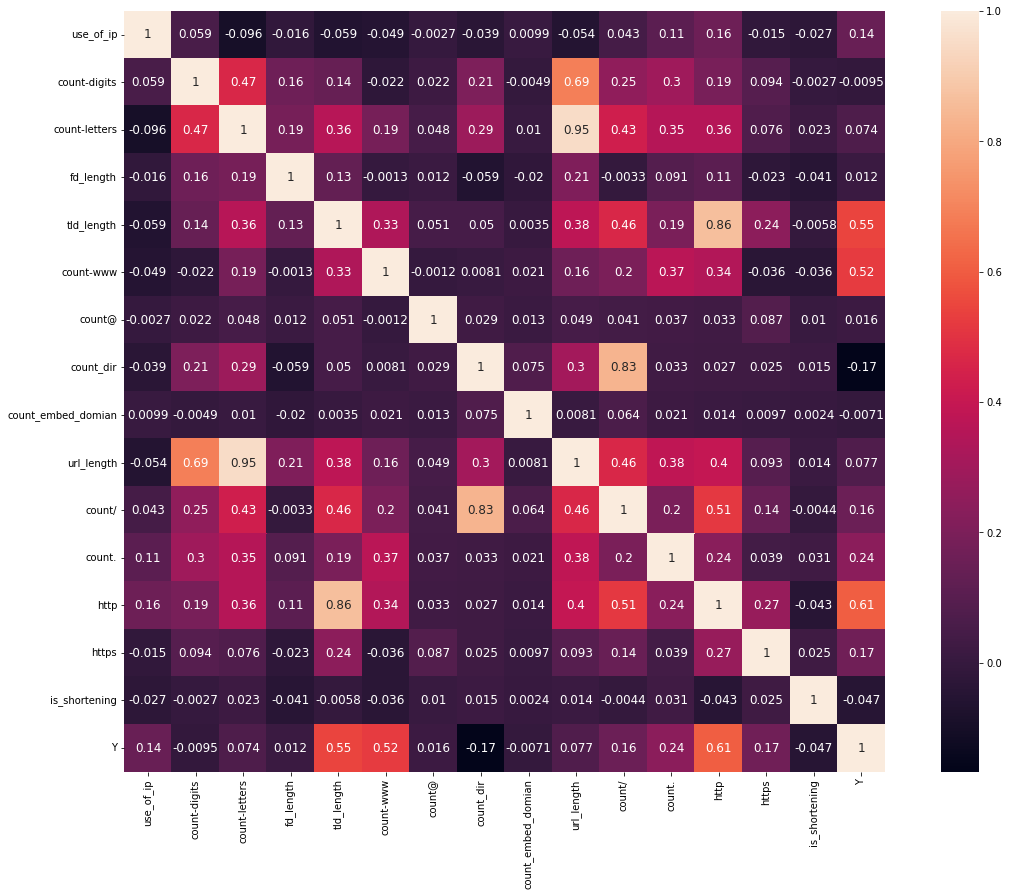

In [ ]:
#Heatmap
corrmat = data.corr()
f, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corrmat, square=True, annot = True, annot_kws={'size':12})

In [ ]:
data.columns

Index(['url', 'type', 'use_of_ip', 'count-digits', 'count-letters',
       'fd_length', 'tld', 'tld_length', 'count-www', 'count@', 'count_dir',
       'count_embed_domian', 'url_length', 'count/', 'count.', 'http', 'https',
       'is_shortening', 'Y'],
      dtype='object')

In [ ]:
#Predictor Variables
X = data[['use_of_ip','count-digits', 'count-letters', 'fd_length',
       'tld_length', 'count-www', 'count@', 'count_dir', 'count_embed_domian',
       'url_length', 'count/', 'count.', 'http', 'https', 'is_shortening']]

#Target Variable
y = data['Y']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

def summarize_model(predictions, labels):
  accuracy_score(labels, predictions)

  print(classification_report(labels, predictions))


  score = accuracy_score(labels, predictions)
  print("accuracy:   %0.3f" % score)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

rfc_predictions = rfc.predict(X_test)
summarize_model(rfc_predictions, y_test)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     85621
           1       0.96      0.95      0.95     44618

    accuracy                           0.97    130239
   macro avg       0.97      0.96      0.97    130239
weighted avg       0.97      0.97      0.97    130239

accuracy:   0.969


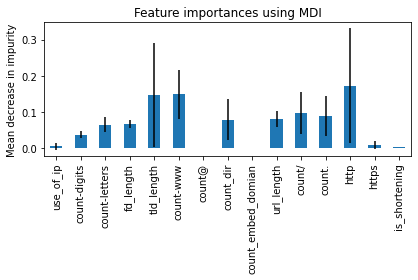

In [ ]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)

feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_model = xgb.XGBClassifier(n_estimators= 100)
xgb_model.fit(X_train,y_train)

xgb_predictions = xgb_model.predict(X_test)

summarize_model(xgb_predictions, y_test)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     85621
           1       0.96      0.91      0.93     44618

    accuracy                           0.96    130239
   macro avg       0.96      0.95      0.95    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.956


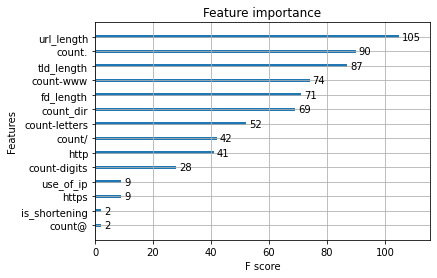

In [ ]:
from xgboost import plot_importance

plot_importance(xgb_model)
plt.show()

We can see both models consider the top level domain length, and www count as important features. This is expected, as we can see in the features correlation confusion matrix there's a relatively high correlation between Y value and these features.

In [ ]:
len(X.columns)

15

In [ ]:
inp = Input(shape=(len(X.columns),))
x = Dense(10, activation='relu', kernel_initializer='uniform')(inp)
# x = Dropout(0.1)(x)
x = Dense(10, activation='relu', kernel_initializer='uniform')(x)
# x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid', kernel_initializer='uniform')(x)

nn_model = Model(inp, x)

# summarize layers
print(nn_model.summary())
# plot graph
plot_model(nn_model, to_file='simple_fnn.png')

nn_model.compile(loss=losses.BinaryCrossentropy(from_logits=True) ,optimizer='RMSProp')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_15 (Dense)            (None, 10)                160       
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def plot_history(hist):
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1006/1018 [============================>.] - ETA: 0s - loss: 0.3903

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1018/1018 [==============================] - 3s 2ms/step - loss: 0.3892 - val_loss: 0.2895
Epoch 2/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2827 - val_loss: 0.2739
Epoch 3/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2728 - val_loss: 0.2701
Epoch 4/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2640 - val_loss: 0.2638
Epoch 5/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2467 - val_loss: 0.2405
Epoch 6/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2272 - val_loss: 0.2153
Epoch 7/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.2093 - val_loss: 0.2005
Epoch 8/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.1939 - val_loss: 0.1904
Epoch 9/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.1859 - val_loss: 0.1845
Epoch 10/15
1018/1018 [==============================] - 2s 2ms/step - loss: 0.1803 - val_los

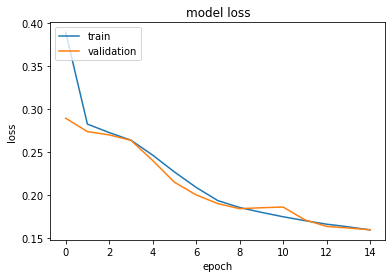

In [ ]:
history = nn_model.fit(X_train, y_train,epochs=15,
                 validation_data=[X_test,y_test],batch_size = 512)
plot_history(history)

In [ ]:
nn_model_predictions = [0 if probability < 0.5 else 1 for probability in nn_model.predict(X_test)]

summarize_model(nn_model_predictions, y_test)

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     85621
           1       0.96      0.87      0.91     44618

    accuracy                           0.94    130239
   macro avg       0.94      0.92      0.93    130239
weighted avg       0.94      0.94      0.94    130239

accuracy:   0.940


As we can see, this basic neural network which uses only the lexical features extracted, produces inferior performance copmared to both the XGBoost and the Random Forest models.

We can investigate a different route - representing the URLs as a stream of charcters, and trying to find these characters' embeddings. Later on, these embeddings will be convoluted over, to find different relationships between their respective positions in the URL.

This method is a somewhat simplified version of the architecture offered in URLNet (https://arxiv.org/pdf/1802.03162.pdf).

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

data['lower_url'] = data['url'].apply(lambda i: i.lower())

# =======================Convert string to index================
# Tokenizer
tk = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tk.fit_on_texts(data.lower_url)

# Convert string to index
data['sequences'] = tk.texts_to_sequences(data.lower_url)

# Padding
padded_urls = pad_sequences(data.sequences, maxlen=200, padding='post')

[[21 11 18 ...  0  0  0]
 [12 15 30 ...  0  0  0]
 [21  4 15 ...  0  0  0]
 ...
 [19 19 19 ...  0  0  0]
 [ 2  8 13 ...  0  0  0]
 [19 19 19 ...  0  0  0]]


In [ ]:
len(tk.word_index)

277

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 14)      3892        ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 200, 128)     5504        ['embedding[0][0]']              
                                                                                                  
 conv1d_1 (Conv1D)              (None, 200, 128)     7296        ['embedding[0][0]']              
                                                                                              

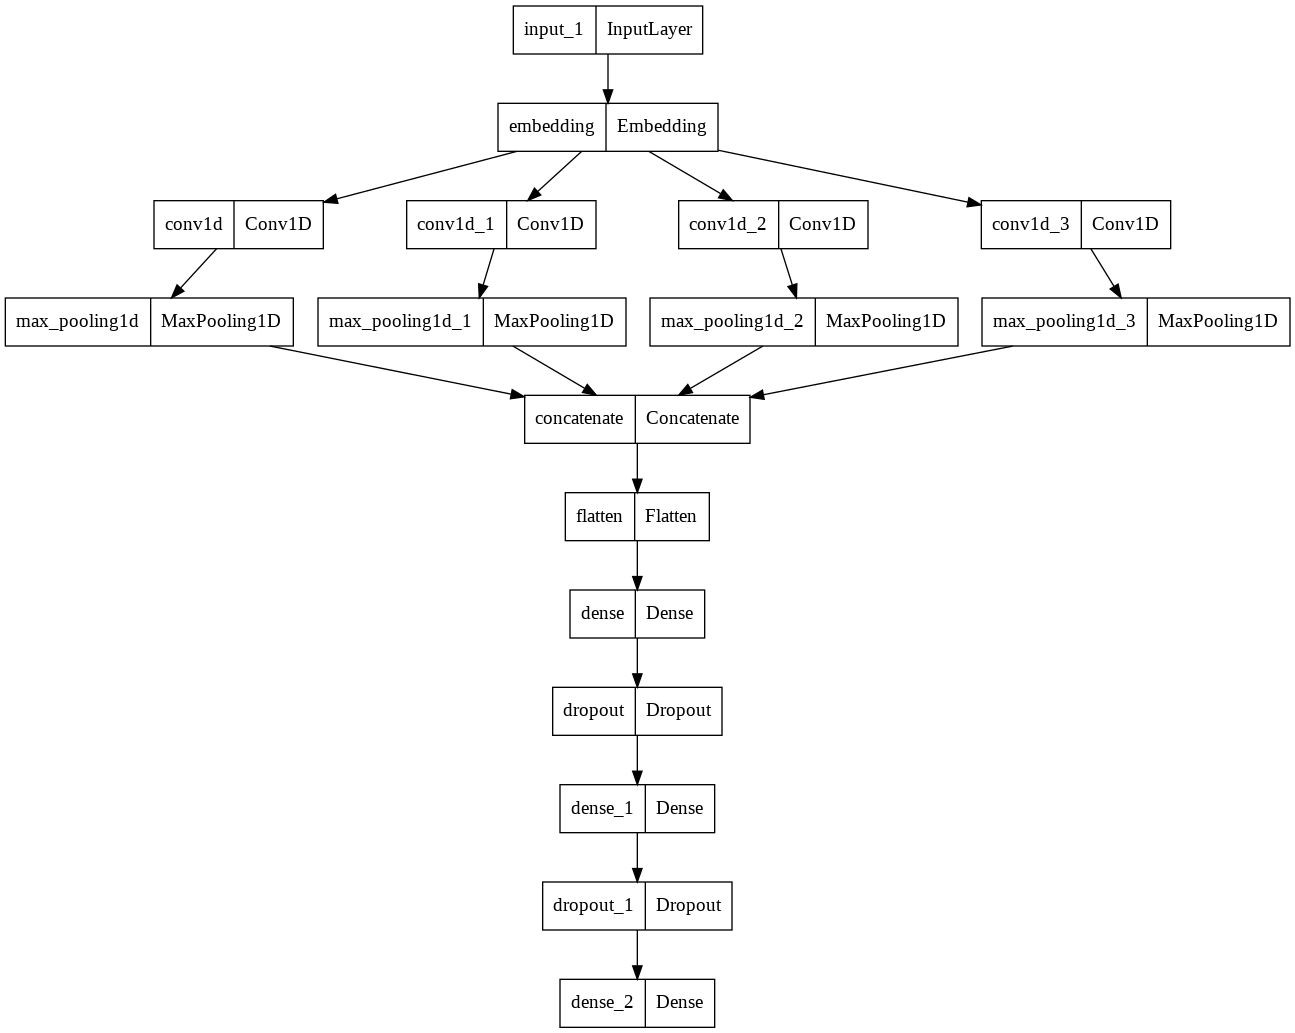

In [ ]:
input = Input(shape=(200,), dtype='int64')
embedding = Embedding(len(tk.word_index) + 1, 14, input_length = 200) (input)
x3 = Conv1D(128, 3, activation='relu', padding='same')(embedding)
x3 = MaxPooling1D()(x3)

x4 = Conv1D(128, 4, activation='relu', padding='same')(embedding)
x4 = MaxPooling1D()(x4)

x5 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
x5 = MaxPooling1D()(x5)

x6 = Conv1D(128, 6, activation='relu', padding='same')(embedding)
x6 = MaxPooling1D()(x6)

x = concatenate([x3, x4, x5, x6], axis=2)

x = Flatten()(x)

x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)

out = Dense(1, activation='sigmoid')(x)

conv_model = Model(inputs=input, outputs=out)
conv_model.compile(loss=losses.BinaryCrossentropy(from_logits=True) ,optimizer='RMSProp', metrics='accuracy')

# summarize layers
print(conv_model.summary())
# plot graph
plot_model(conv_model, to_file='cnn.png')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_urls, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

Epoch 1/4
255/255 [==============================] - 176s 691ms/step - loss: 0.0446 - accuracy: 0.9857 - val_loss: 0.0607 - val_accuracy: 0.9795
Epoch 2/4
255/255 [==============================] - 176s 690ms/step - loss: 0.0379 - accuracy: 0.9881 - val_loss: 0.0507 - val_accuracy: 0.9833
Epoch 3/4
255/255 [==============================] - 176s 690ms/step - loss: 0.0349 - accuracy: 0.9888 - val_loss: 0.0520 - val_accuracy: 0.9851
Epoch 4/4
255/255 [==============================] - 176s 689ms/step - loss: 0.0328 - accuracy: 0.9896 - val_loss: 0.0506 - val_accuracy: 0.9835


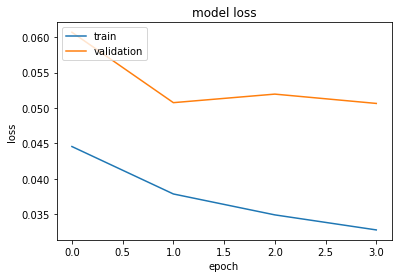

In [ ]:
history = conv_model.fit(X_train, y_train,epochs=4,
                 validation_data=[X_test,y_test],batch_size = 2048)
plot_history(history)

In [ ]:
conv_model_predictions = [0 if probability < 0.5 else 1 for probability in conv_model.predict(X_test)]

summarize_model(conv_model_predictions, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     85621
           1       0.98      0.98      0.98     44618

    accuracy                           0.98    130239
   macro avg       0.98      0.98      0.98    130239
weighted avg       0.98      0.98      0.98    130239

accuracy:   0.983


Indeed a better performance is displayed by this model compared to the previous models.
While Convolutional layers take advantage of spatial information, RNN cells like LSTM can draw conclusion from historical data, and perhaps may outperform this architecture.

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 14)      3892        ['input_4[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 200, 128)     5504        ['embedding_3[0][0]']            
                                                                                                  
 conv1d_13 (Conv1D)             (None, 200, 128)     7296        ['embedding_3[0][0]']            
                                                                                            

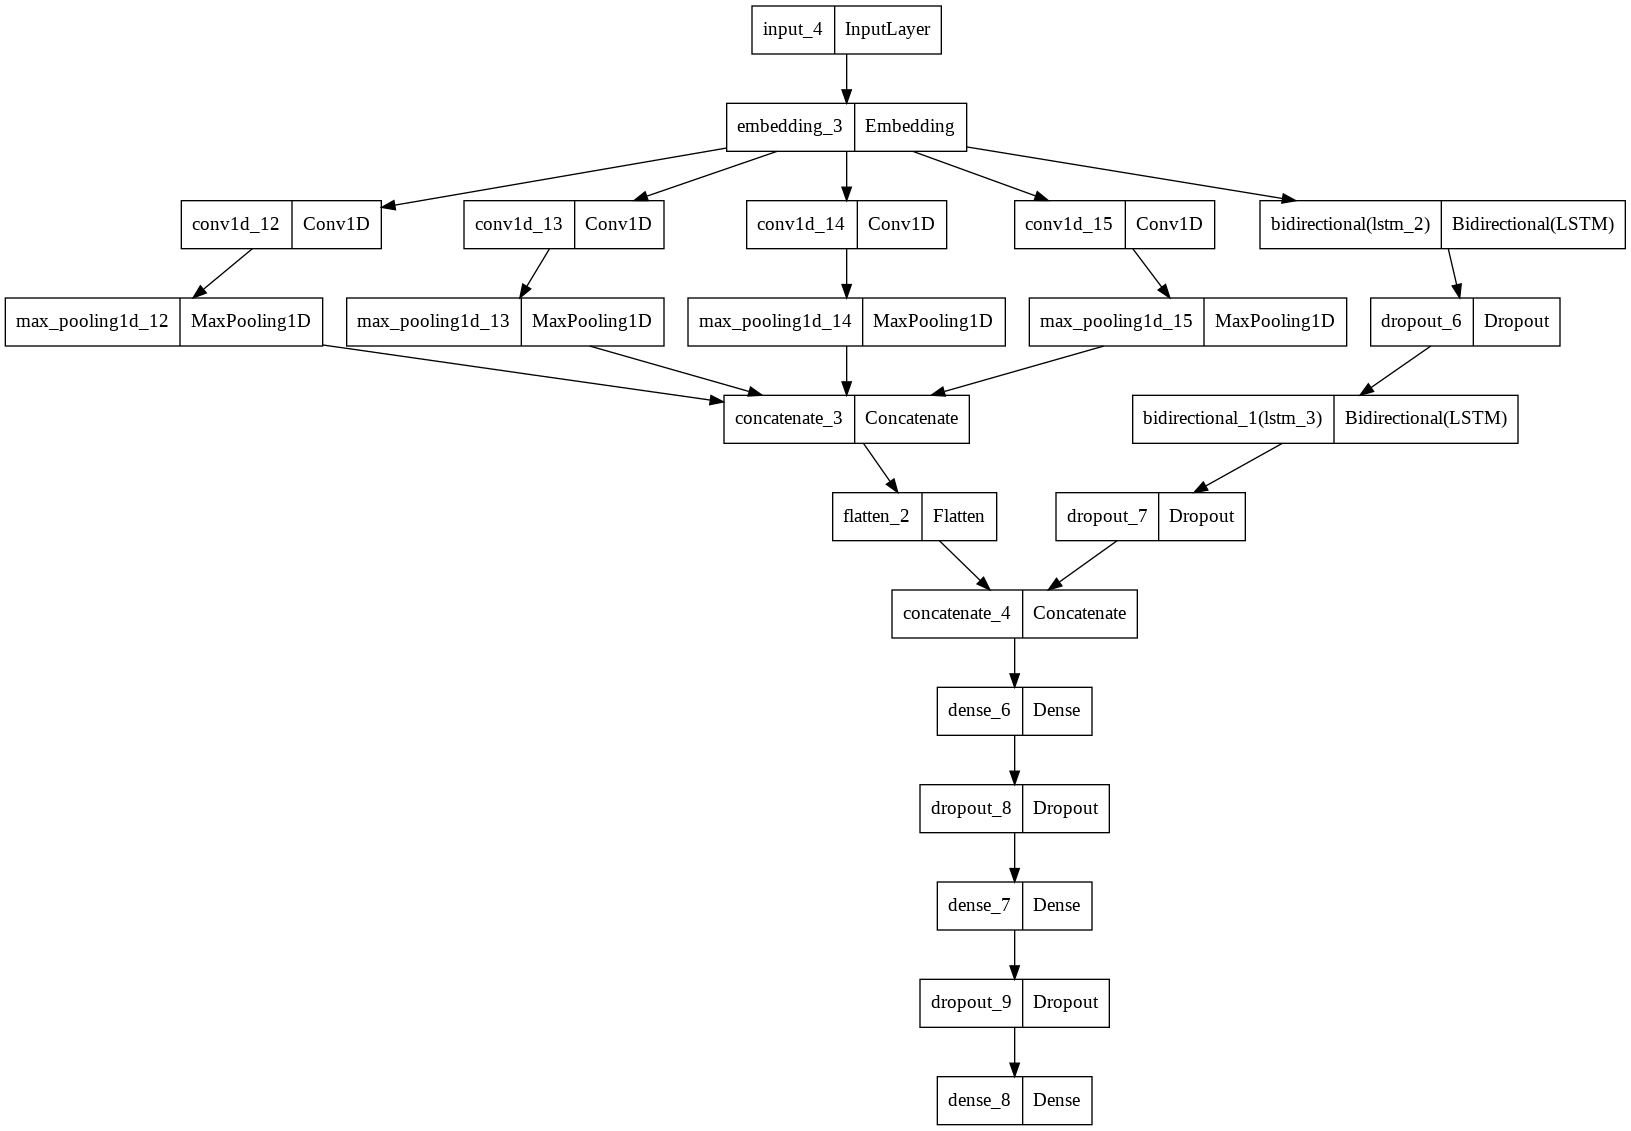

In [ ]:
input = Input(shape=(200,), dtype='int64')
embedding = Embedding(len(tk.word_index) + 1, 14, input_length = 200) (input)
x3 = Conv1D(128, 3, activation='relu', padding='same')(embedding)
x3 = MaxPooling1D()(x3)

x4 = Conv1D(128, 4, activation='relu', padding='same')(embedding)
x4 = MaxPooling1D()(x4)

x5 = Conv1D(128, 5, activation='relu', padding='same')(embedding)
x5 = MaxPooling1D()(x5)

x6 = Conv1D(128, 6, activation='relu', padding='same')(embedding)
x6 = MaxPooling1D()(x6)

lstm = Bidirectional(LSTM(32,activation='relu',return_sequences=True))(embedding)
lstm = Dropout(0.2)(lstm)
lstm = Bidirectional(LSTM(32,activation='relu'))(lstm)
lstm = Dropout(0.2)(lstm)

x = concatenate([x3, x4, x5, x6], axis=2)

x = Flatten()(x)

x = concatenate([x, lstm], axis=-1)

x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)

x = Dense(1000, activation='relu')(x)
x = Dropout(0.5)(x)

out = Dense(1, activation='sigmoid')(x)

conv_lstm_model = Model(inputs=input, outputs=out)
conv_lstm_model.compile(loss=losses.BinaryCrossentropy(from_logits=True) ,optimizer='RMSProp', metrics='accuracy')

# summarize layers
print(conv_lstm_model.summary())
# plot graph
plot_model(conv_lstm_model, to_file='conv_lstm_model.png')


Epoch 1/4
255/255 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9496

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


255/255 [==============================] - 738s 3s/step - loss: 0.1478 - accuracy: 0.9496 - val_loss: 0.0913 - val_accuracy: 0.9738
Epoch 2/4
255/255 [==============================] - 737s 3s/step - loss: 0.0745 - accuracy: 0.9764 - val_loss: 0.0728 - val_accuracy: 0.9770
Epoch 3/4
255/255 [==============================] - 794s 3s/step - loss: 0.0559 - accuracy: 0.9822 - val_loss: 0.0571 - val_accuracy: 0.9817
Epoch 4/4
255/255 [==============================] - 734s 3s/step - loss: 379683.3125 - accuracy: 0.9850 - val_loss: 0.0557 - val_accuracy: 0.9818


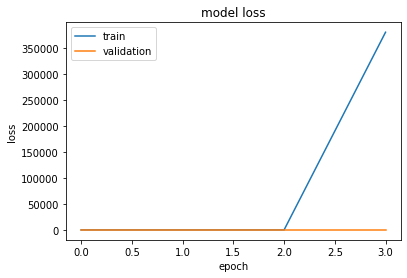

In [ ]:
history = conv_lstm_model.fit(X_train, y_train,epochs=4,
                 validation_data=[X_test,y_test],batch_size = 2048)
plot_history(history)

In [ ]:
conv_lstm_model_predictions = [0 if probability < 0.5 else 1 for probability in conv_lstm_model.predict(X_test)]

summarize_model(conv_lstm_model_predictions, y_test)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     85621
           1       0.97      0.97      0.97     44618

    accuracy                           0.98    130239
   macro avg       0.98      0.98      0.98    130239
weighted avg       0.98      0.98      0.98    130239

accuracy:   0.982


Evidentally, this more complex model doesn't show a significant improvement in predictions, and is way more expansive to both train and predict. Let's make predictions on our test dataset, and see what we get.

In [ ]:
phishtank_df = pd.read_csv(folder+'verified_online.csv',engine="python")

phishtank_df['lower_url'] = phishtank_df['url'].apply(lambda i: i.lower())

# =======================Convert string to index================

# Convert string to index
phishtank_df['sequences'] = tk.texts_to_sequences(phishtank_df.lower_url)

# Padding
padded_urls = pad_sequences(phishtank_df.sequences, maxlen=200, padding='post')

X_phishtank = padded_urls
y_phishtank = phishtank_df.verified.apply(lambda i: 1 if(i == 'yes') else 0 )

conv_model_phish_predictions = [0 if probability < 0.5 else 1 for probability in conv_model.predict(X_phishtank)]

summarize_model(conv_model_phish_predictions, y_phishtank)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.98      0.99     13116

    accuracy                           0.98     13116
   macro avg       0.50      0.49      0.50     13116
weighted avg       1.00      0.98      0.99     13116

accuracy:   0.985


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We can see the performance demonstaretd on the training set is comparable to the one on the test set - the data provided from phishtank.

Future work:

1. Further implement URLNet architecture (use words embeddings as well).
2. Incorporate the lexical extracted features into a model along with the CNN over embeddings
3. Stack XGBoost, Random Forest and the CNN model.
4. Try using XGBoost over the embbedings, in connjunction with the existing lexical features.
